In [3]:
!nvidia-smi

Tue Dec 24 09:49:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 38.4 MB/s eta 0:00:00


In [5]:
from  ultralytics import YOLO
import os
from IPython.display import Image, display
from IPython import display
display.clear_output()
!yolo mode=checks

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 911, in entrypoint
    raise ValueError(f"Invalid 'mode={mode}'. Valid modes are {MODES}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'mode=<module 'ultralytics.utils.checks' from '/usr/local/lib/python3.10/dist-packages/ultralytics/utils/checks.py'>'. Valid modes are {'train', 'benchmark', 'val', 'track', 'export', 'predict'}.

    Arguments received: ['yolo', 'mode=checks']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'detect', 'obb', 'pose', 'segment', 'classify'}
                MODE (required) is one of {'train', 'benchmark', 'val', 'track', 'export', 'predict'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at ht

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PCrgPREu5U98Utnp1eI6")
project = rf.workspace("kalay-high-school-ma6a4").project("flag_detection-xksf7")
version = project.version(2)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to flag_detection-2 in yolov8:: 100%|██████████| 492/492 [00:00<00:00, 8649.72it/s]


In [7]:
!yolo task=detect mode=train model=yolov8m.pt data={dataset.location}/data.yaml epochs=20 imgsz=640

100% 49.7M/49.7M [00:00<00:00, 98.2MB/s]
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/flag_detection-2/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
def detect_flag(image_path, model_path):
    # Load the YOLO model
    model = YOLO(model_path)

    # Perform detection
    results = model.predict(image_path)

    # Read the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Get the bounding boxes for detected flags
    for result in results:
        for box in result.boxes.data:
            x1, y1, x2, y2, confidence, class_id = box
            if confidence > 0.2:  # Threshold for confidence
                # Extract the bounding box region
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                cv2.rectangle(original_image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw bounding box
                cropped_flag = original_image[y1:y2, x1:x2]  # Crop the flag region
                return cropped_flag, original_image  # Return both cropped flag and image with bounding box

    return None, original_image

In [21]:
def classify_flag(flag_image):
    image = Image.fromarray(flag_image)
    image = image.resize((100, 100))

    # Split the image into top and bottom halves
    top_half = image.crop((0, 0, 100, 50))
    bottom_half = image.crop((0, 50, 100, 100))

    # Calculate the average intensity for the top and bottom halves
    def average_intensity(img):
        pixels = np.array(img)
        return pixels.mean()

    top_avg = average_intensity(top_half)
    bottom_avg = average_intensity(bottom_half)

    if top_avg < bottom_avg:  # Darker top indicates Indonesia
        return "Indonesia Flag"
    else:  # Brighter top indicates Poland
        return "Poland Flag"



image 1/1 /content/poland.jpg: 640x448 1 netherlands, 39.5ms
Speed: 3.1ms preprocess, 39.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)
Flag Classification: Poland Flag


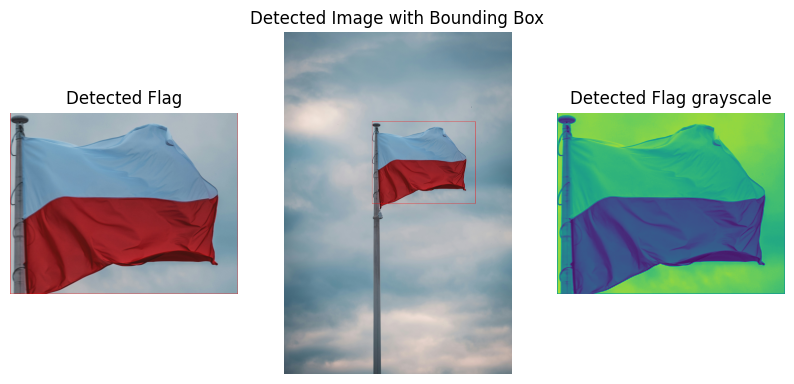

In [23]:
if __name__ == "__main__":
    # Path to the input image
    image_path = "/content/poland.jpg"

    # Path to the YOLO model weights
    model_path = "/content/runs/detect/train/weights/best.pt"

    # Detect the flag in the image
    flag_image, detected_image = detect_flag(image_path, model_path)
    gray_image = Image.fromarray(flag_image)
    gray_image = gray_image.convert("L")  # Convert to grayscale
    gray_image = np.array(gray_image)
    # Classify the flag
    result = classify_flag(gray_image)
    print(f"Flag Classification: {result}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Detected Flag")
    plt.imshow(flag_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Detected Image with Bounding Box")
    plt.imshow(detected_image)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Detected Flag grayscale")
    plt.imshow(gray_image)
    plt.axis("off")

    plt.show()
